In [2]:
pip install pandas numpy scikit-learn nltk matplotlib seaborn


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
fake_df = pd.read_csv("Fake.csv", engine='python', on_bad_lines='skip')
true_df = pd.read_csv("True.csv", engine='python', on_bad_lines='skip')

fake_df['label'] = 1
true_df['label'] = 0
news_df = pd.concat([fake_df, true_df], axis=0)

print(news_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  


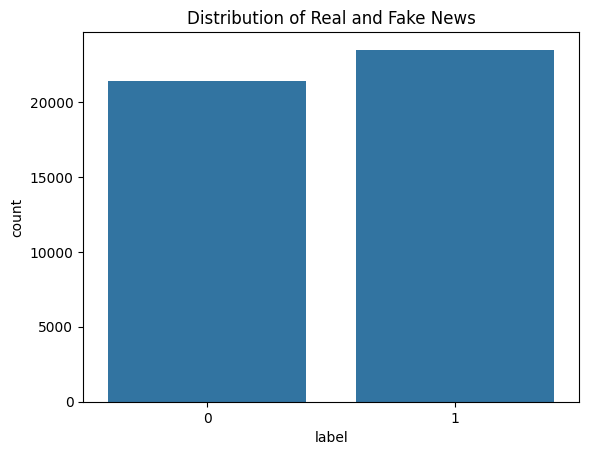

In [5]:

sns.countplot(x='label', data=news_df)
plt.title('Distribution of Real and Fake News')
plt.show()


In [6]:
def clean_text(text):

    text = text.lower()

    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


news_df['cleaned_text'] = news_df['text'].apply(clean_text)


print(news_df['cleaned_text'].head())


0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: cleaned_text, dtype: object


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(news_df['cleaned_text']).toarray()
y = news_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (35918, 5000)
Test set size: (8980, 5000)


In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



Model Accuracy: 98.85%


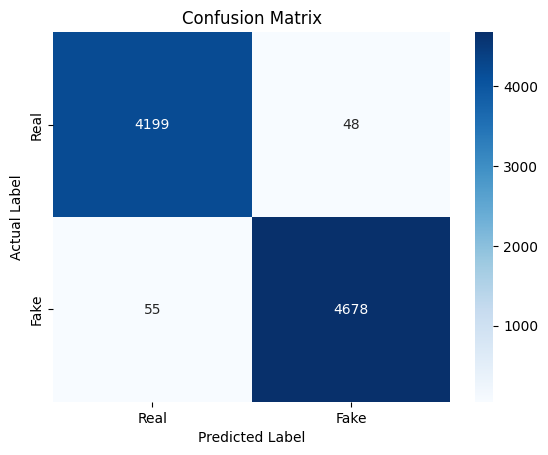

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4247
           1       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [9]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")


conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred))


Word Cloud for Fake News


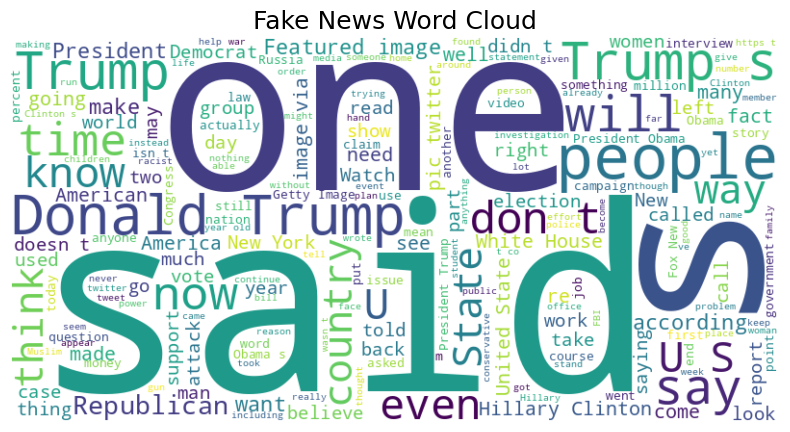

Word Cloud for Real News


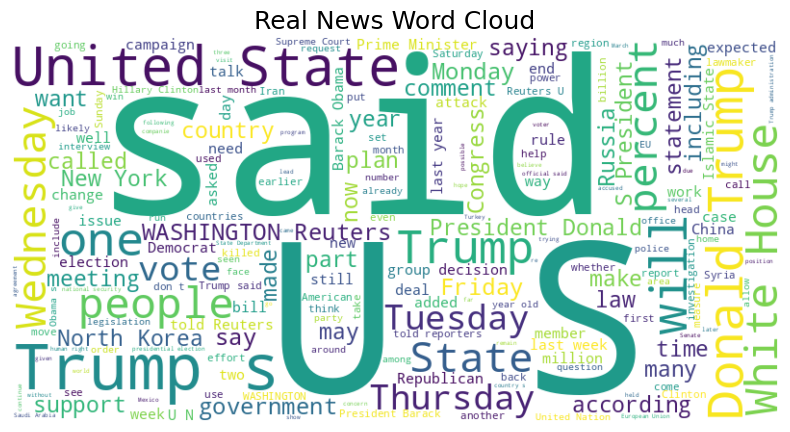

In [10]:
from wordcloud import WordCloud


def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

fake_news_text = ' '.join(fake_df['text'])
real_news_text = ' '.join(true_df['text'])

print("Word Cloud for Fake News")
plot_wordcloud(fake_news_text, 'Fake News Word Cloud')

print("Word Cloud for Real News")
plot_wordcloud(real_news_text, 'Real News Word Cloud')


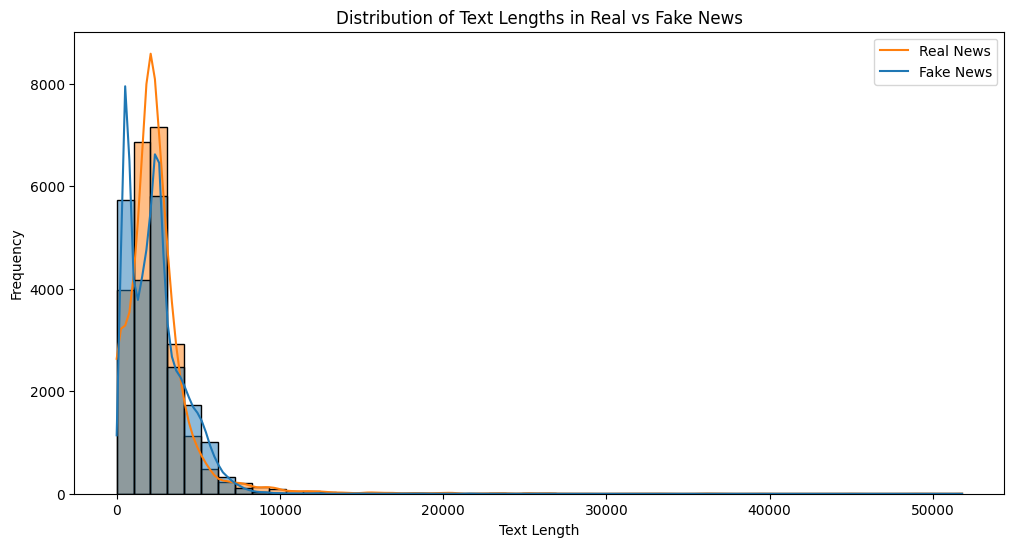

In [11]:
news_df['text_length'] = news_df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=news_df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Lengths in Real vs Fake News')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(['Real News', 'Fake News'])
plt.show()


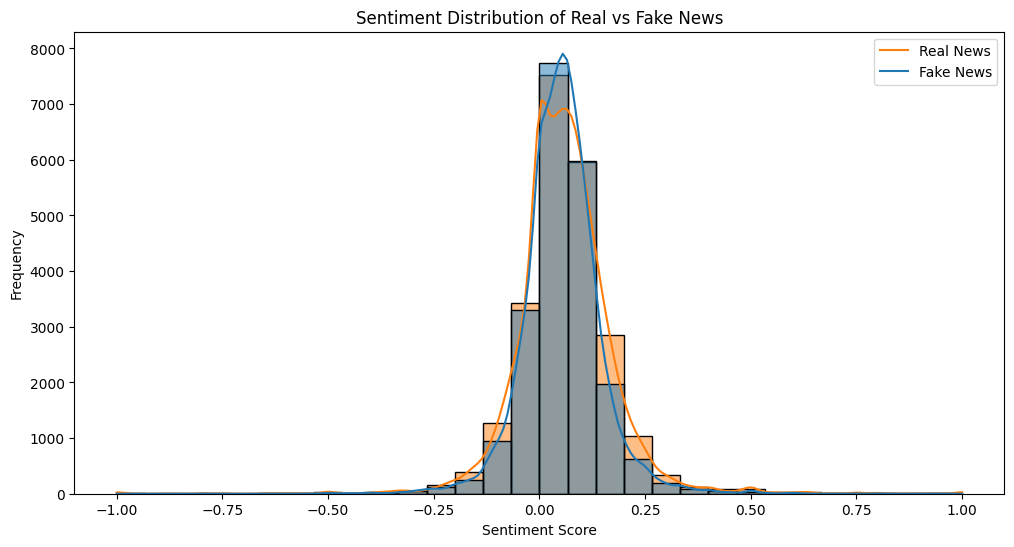

In [12]:
from textblob import TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

news_df['sentiment'] = news_df['text'].apply(get_sentiment)

plt.figure(figsize=(12, 6))
sns.histplot(data=news_df, x='sentiment', hue='label', bins=30, kde=True)
plt.title('Sentiment Distribution of Real vs Fake News')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(['Real News', 'Fake News'])
plt.show()


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100)
bi_grams = count_vectorizer.fit_transform(news_df['cleaned_text'])

bi_grams_df = pd.DataFrame(bi_grams.toarray(), columns=count_vectorizer.get_feature_names_out())

bi_grams_sum = bi_grams_df.sum(axis=0)
common_bi_grams = bi_grams_sum.sort_values(ascending=False).head(10)
print(common_bi_grams)


donald trump          23303
united states         18357
white house           14585
hillary clinton        8890
new york               8525
president donald       6934
washington reuters     6488
image via              6192
north korea            6127
trump said             4792
dtype: int64


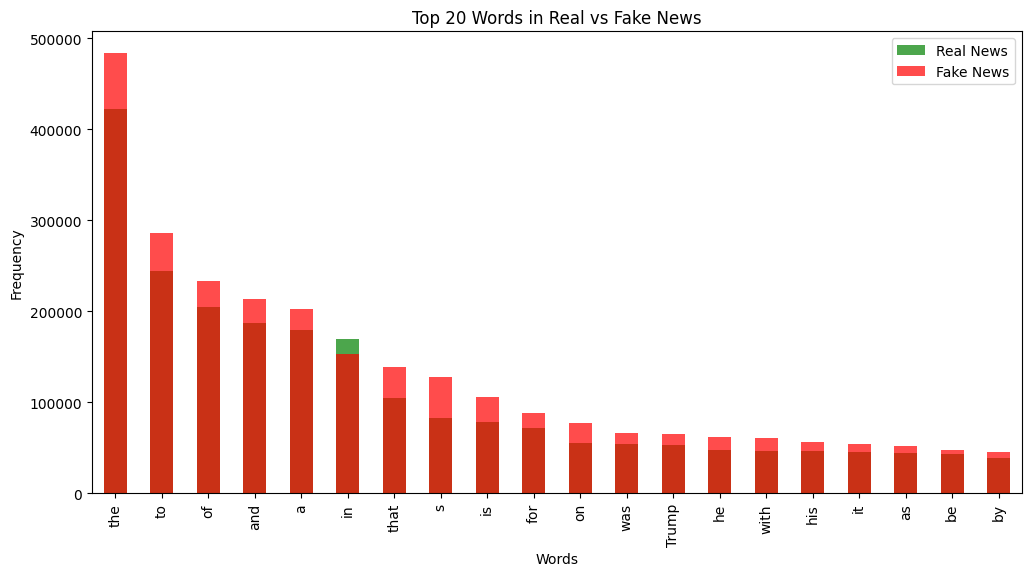

In [14]:
real_words = ' '.join(real_news_text.split())
fake_words = ' '.join(fake_news_text.split())

real_word_freq = pd.Series(real_words.split()).value_counts().head(20)
fake_word_freq = pd.Series(fake_words.split()).value_counts().head(20)

plt.figure(figsize=(12, 6))
real_word_freq.plot(kind='bar', color='green', alpha=0.7, label='Real News')
fake_word_freq.plot(kind='bar', color='red', alpha=0.7, label='Fake News')
plt.title('Top 20 Words in Real vs Fake News')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:

def predict_news(news_text):
    cleaned_text = clean_text(news_text)
    if cleaned_text:
        vectorized_text = tfidf_vectorizer.transform([cleaned_text])
        prediction = model.predict(vectorized_text)
        label = 'Real' if prediction[0] == 0 else 'Fake'
        return label
    return "Invalid input"

news_text = input("Enter a news article: ")
prediction = predict_news(news_text)
print(f"The news is predicted to be: {prediction}")
